# Single Frame CNN Model

### Install all the necessary python packages

In [1]:
!pip install pafy youtube-dl moviepy
!pip install opencv-python
!pip install tensorflow
!pip install matplotlib
!pip install scikit-learn
!pip install scipy

### Import all necessary libraries

In [1]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

### Set the seed constant 

The seed value is used to generate the random number generator. And, every time you use the same seed value, you will get the same random values.

In [2]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

### Get the names of all classes in dataset

In [3]:
all_classes_names = os.listdir('GMS')

### Visualize a random sample videos from the dataset for each category

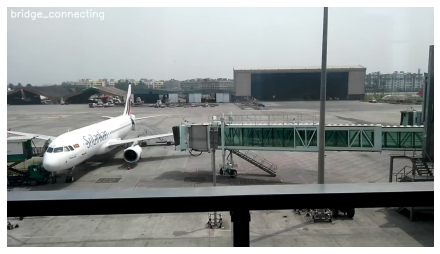

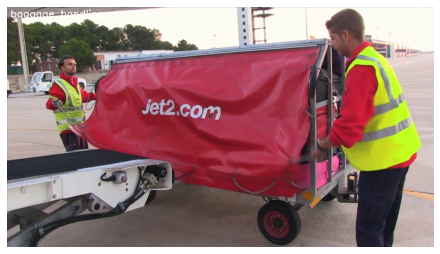

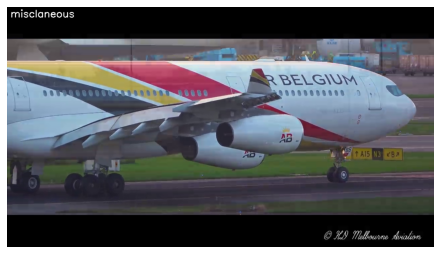

In [4]:
random_range = random.sample(range(len(all_classes_names)), 3)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'GMS/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'GMS/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 1, counter);
    plt.imshow(rgb_frame);
    plt.axis('off')

### Data Preprocessing

Since we are going to use a classification architecture to train on a video classification dataset, we need to preprocess the dataset first.

This is the size we will resize all frames of the video to, we are doing this to avoid unnecessary computation.

In [5]:
image_height, image_width = 64, 64

Maximum number of training images allowed for each class.

In [6]:
max_images_per_class = 4000

The path of the directory containing the extracted dataset.

In [7]:
dataset_directory = "GMS"

These are the list of classes we are going to be training on, we are training on following 2 classes, you can feel free to change it.

In [8]:
classes_list = ["bridge_connecting", "baggage_handling", "misclaneous"]

Define model output size

In [9]:
model_output_size = len(classes_list)

Note: The image_height, image_width and max_images_per_class are constants. This can be increased for better results, but be warned this will become computationally expensive.

This "frame_extraction" method takes a video file path as input. It then reads the video file frame by frame, resizes each frame, normalizes the resized frame, appends the normalized frame into a list, and then finally returns that list.

In [10]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []

    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file
        success, frame = video_reader.read()

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Closing the VideoCapture object and releasing all resources.
    video_reader.release()

    # returning the frames list
    return frames_list

The "create_dataset" methods iterates through all the classes mentioned in the class list and get the list of video files in the specific class name directory. Then, it iterates through all the files present in the files list and calls frame_extraction methods for every video file path. This is followed by appending the frames to a temporary list. Further, it adds randomly selected frames to the feature list and fixed number of labels to the labels list. The temporary features list is cleared so it can be reused to store all frames of the next class. Atlast, we converting the features and labels lists to numpy arrays.

In [11]:
def create_dataset():
    # Declaring Empty Lists to store the features and labels values.
    temp_features = []
    features = []
    labels = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')

        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:
            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)

        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)

        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels

Calling the "create_dataset" method which returns features and labels.

In [ ]:
features, labels = create_dataset()

Extracting Data of Class: bridge_connecting
Extracting Data of Class: baggage_handling
Extracting Data of Class: misclaneous


Now we will convert class labels to one hot encoded vectors using kera's to_categorical method.

In [14]:
one_hot_encoded_labels = to_categorical(labels)

### Split the Data into Train and Test Sets

Now we have two numpy arrays, one containing all images. The second one contains all class labels in one hot encoded format. Let us split our data to create a training, and a testing set. We must shuffle the data before the split, which we have already done.

In [15]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

### Define the model

Let's create a "create_model" function that will construct our model. Here, we will be using sequential model for model construction. 

### Model Architecture:

This has got 2 Conv2D layers with 64 filters with kernel size as 3x3 with relu as activation layer. 

Followed by this, BatchNormalization is added to perform normalization technique between the layers of neural network. This is done along mini-batches instead of full dataset. It serves to speed up the training and use higher learning rates, making learning easier. It provides some regularization and reduces generalization error. 

Then, Max pooling layer is added to perform pooling operation that calculates the maximum value for patches of a feature map, and uses it to create a downsampled feature map. It is usually used after a convolutional layer. This highlights the most present feature in the patch and reduces the spatial size of the representation by reducing the amount of parameters and computation in the network. Internally, it reduces the dimensionality of images by reducing the number of pixels in the output from the previous convolutional layer.

Global Average Pooling is added to replace full connected layers in classical CNNs. The idea is to generate one feature map for each coressponding category of the classification task. The 2D Global average pooling block takes a tensor of size (input width) x (input height) x (input channels) and computes the average value of all values across the entire (input width) x (input height) matrix for each of the (input channels).

ReLU sets all negative values in the matrix x to zero and all other values are kept constant. ReLU is computed after the convolution and is a nonlinear activation function like tanh or sigmoid. More computationally efficient to compute than Sigmoid. Just needs to pick max(0, x) and not perform expensive exponential operations. Relu tend to show better convergence performance than sigmoid.

Softmax activation function in the final output layer when you are trying to solve the Classification problems where your labels are class values. It predicts a multinomial probability distribution - for multi-class classification problems. A Softmax function is a type of squashing function. Squashing functions limit the output of the function into the range 0 to 1.

In [16]:
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()
    return model

Calling the "create_model" method:

In [17]:
model = create_model()
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

Using the plot_model function, we can check the structure of the final model. This is really helpful when we are creating a complex network, and you want to make sure we have constructed the network correctly.

In [18]:
# plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

Adding Early Stopping Callback:

In [19]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

Adding loss, optimizer and metrics values to the model:

In [20]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

### Model Training

In [21]:
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
1920/1920 [==============================] - 176s 91ms/step - loss: 0.5324 - accuracy: 0.7629 - val_loss: 0.3425 - val_accuracy: 0.8568
Epoch 2/50
1920/1920 [==============================] - 178s 93ms/step - loss: 0.3439 - accuracy: 0.8630 - val_loss: 0.2071 - val_accuracy: 0.9495
Epoch 3/50
1920/1920 [==============================] - 187s 97ms/step - loss: 0.3060 - accuracy: 0.8846 - val_loss: 0.4611 - val_accuracy: 0.8406
Epoch 4/50
1920/1920 [==============================] - 169s 88ms/step - loss: 0.2596 - accuracy: 0.9009 - val_loss: 0.2184 - val_accuracy: 0.9214
Epoch 5/50
1920/1920 [==============================] - 171s 89ms/step - loss: 0.2363 - accuracy: 0.9156 - val_loss: 0.2545 - val_accuracy: 0.8969
Epoch 6/50
1920/1920 [==============================] - 158s 82ms/step - loss: 0.2394 - accuracy: 0.9124 - val_loss: 0.3067 - val_accuracy: 0.9203
Epoch 7/50
1920/1920 [==============================] - 161s 84ms/step - loss: 0.2430 - accuracy: 0.9142 - val_loss: 0

### Model Evaluation

Evaluate your trained model on the feature’s and label’s test sets.

In [22]:
model_evaluation_history = model.evaluate(features_test, labels_test)

75/75 [==============================] - 5s 64ms/step - loss: 0.0954 - accuracy: 0.9787


You should now save your model for future runs.

In [23]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)

### Model Inference

The "plot_metric" method get metrics value using metric names as identifiers and constructs a range object which will be used as time. This function plots the graph, adds title, and legend.

In [24]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
    # Get Metric values using metric names as identifiers
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Constructing a range object which will be used as time
    epochs = range(len(metric_value_1))

    # Plotting the Graph
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)

    # Adding title to the plot
    plt.title(str(plot_name))

    # Adding legend to the plot
    plt.legend()

Visualize the training and validation loss metrices:

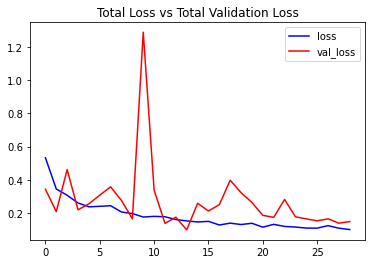

In [25]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

Visualize the training and validation accuracy metrices:

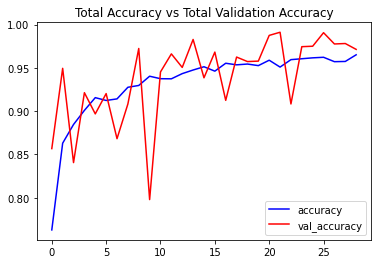

In [26]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')